# Training the Algorithmic Traders

This notebook contains the code for generating and training the LSTM traders. I have used the keras structures that are available with tensorflow as the basis for the struture. This particular notebook defines the functions needed for training and then trains and develops lstm1.

In [55]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [36]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

In [56]:
gen0 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen0_sims/data") #Load gen0 data

In [38]:
def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

In [57]:
X, y = format_data(gen0, 20)
print(X.shape)
print(y.shape)

(31380, 20, 2)
(31380, 1)


In [40]:
def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [58]:
X_train, y_train, X_test, y_test = split_data(X, y, 0.8)
X_train, y_train, Xscale, yscale = normalise_data(X_train, y_train)
X_test, y_test, _, _ = normalise_data(X_test, y_test)

In [59]:
print(Xscale.mean_)
print(Xscale.var_)
print(yscale.mean_)
print(yscale.var_)

[4.73053996 4.78413082]
[0.03715021 0.01395239]
[4.73700706]
[0.04016007]


In [60]:
lstm1=keras.Sequential() #Set up the architecture of the model

lstm1.add(layers.LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm1.add(layers.Dropout(0.2))

lstm1.add(layers.Dense(units=1))

In [61]:
lstm1.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history1 = lstm1.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 20083 samples, validate on 5021 samples
Epoch 1/10
20083/20083 [==============================] - 38s 2ms/sample - loss: 0.1618 - val_loss: 0.0149
Epoch 2/10
20083/20083 [==============================] - 23s 1ms/sample - loss: 0.0320 - val_loss: 0.0187
Epoch 3/10
20083/20083 [==============================] - 24s 1ms/sample - loss: 0.0274 - val_loss: 0.0243
Epoch 4/10
20083/20083 [==============================] - 25s 1ms/sample - loss: 0.0253 - val_loss: 0.0089
Epoch 5/10
20083/20083 [==============================] - 23s 1ms/sample - loss: 0.0243 - val_loss: 0.0167
Epoch 6/10
20083/20083 [==============================] - 25s 1ms/sample - loss: 0.0232 - val_loss: 0.0038
Epoch 7/10
20083/20083 [==============================] - 27s 1ms/sample - loss: 0.0221 - val_loss: 0.0041
Epoch 8/10
20083/20083 [==============================] - 30s 1ms/sample - loss: 0.0212 - val_loss: 0.0025
Epoch 9/10
20083/20083 [==============================] - 27s 1ms/sample - loss: 0.0197 - val_l

In [45]:
#print(lstm1.summary())

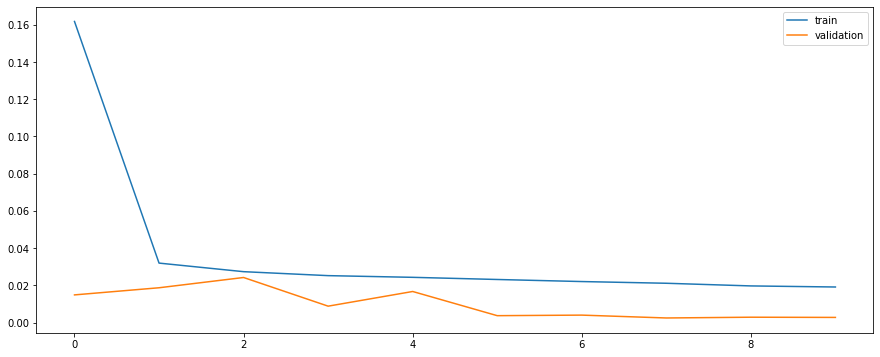

In [62]:
plt.figure(figsize=(15,6))
plt.plot(history1.history["loss"], label="train")
plt.plot(history1.history["val_loss"], label="validation")
plt.legend()

In [50]:
y_pred = lstm1.predict(X_test)
y_train_inv = yscale.inverse_transform(y_train.reshape(1, -1))
y_test_inv = yscale.inverse_transform(y_test.reshape(1, -1))
y_pred_inv  = yscale.inverse_transform(y_pred)

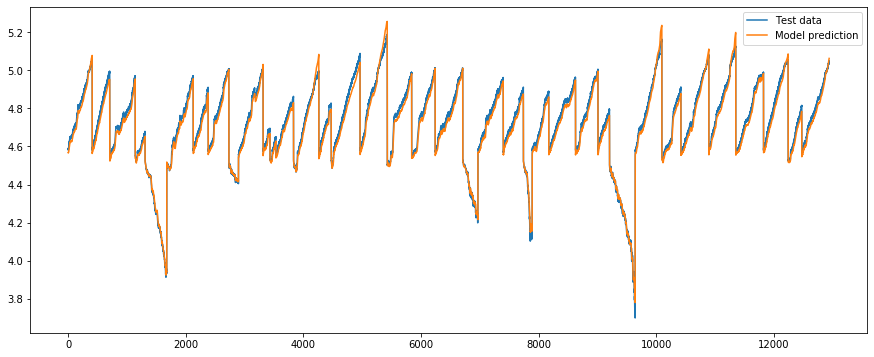

In [63]:
plt.figure(figsize=(15,6))
plt.plot(y_test_inv.flatten(), label="Test data")
plt.plot(y_pred_inv.flatten(), label="Model prediction")
plt.legend()

In [30]:
#test1 = lstm1(X_train[0:1]).numpy()
#test1 = yscale.inverse_transform(test1.reshape(1, -1))
#test2 = float(test1)
#test3 = math.exp(test2)
#print(test3)
#print(test1.shape)
#print(X_train[0:1].shape)

In [64]:
lstm1.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm1")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm1/assets
